In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [2]:
data_dir = 'ml-1m'

movies_filename = 'movies.dat'
users_filename = 'users.dat'
ratings_filename = 'ratings.dat'

movies_columns = ['MovieID', 'Title', 'Genres']
users_columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
ratings_columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

def create_dataframe(data_dir, filename, columns):
    data_file = os.path.join(data_dir, filename)
    return pd.read_csv(data_file, delimiter='::', names=columns, encoding='latin-1', engine='python')

movies = create_dataframe(data_dir, movies_filename, movies_columns)
users = create_dataframe(data_dir, users_filename, users_columns)
ratings = create_dataframe(data_dir, ratings_filename, ratings_columns)
data = (users, movies, ratings)

In [3]:
def rating_error(test_set, model, subset:int=None):
    if subset is not None:
        actual_ratings = test_set[:subset]['Rating']
        predicted_ratings = test_set[:subset].apply(model, axis=1)
    else:
        actual_ratings = test_set['Rating']
        predicted_ratings = test_set.apply(model, axis=1)

    rating_error = ((actual_ratings - predicted_ratings)**2).mean()**(1/2)
    return rating_error

In [4]:
# Overall mean rating 
mean_rating = ratings['Rating'].mean()

# Lookup tables for naive models 2, 3, 4 and 5
mean_rating_per_user = {user_id : ratings[ratings['UserID'] == user_id]['Rating'].mean() for user_id in users['UserID']}
mean_rating_per_movie = {movie_id : ratings[ratings['MovieID'] == movie_id]['Rating'].mean() for movie_id in movies['MovieID']}

In [5]:
def test_naive_model_1(data, subset:int=None):
    users, movies, ratings = data
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    rating_errors = np.array([])
        
    for train_index, test_index in cv.split(ratings):
        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index]
        mean_rating = train_set['Rating'].mean()
        
        def model(row):
            return mean_rating
        
        rating_err = rating_error(test_set, model, subset)
        print(rating_err)
        
        rating_errors = np.append(rating_errors, rating_err)
    return rating_errors

errors = test_naive_model_1(data)
mean_error = np.mean(errors)
print('mean error', mean_error)

1.119729345062511
1.1149881214282826
1.1162190943284103
1.1180847521411108
1.1164859396819586
mean error 1.1171014505284547


In [7]:
def test_naive_model_2(data, subset:int=None):
    users, movies, ratings = data
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    rating_errors = np.array([])
        
    for train_index, test_index in cv.split(ratings):
        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index]
        user_ids = train_set['UserID']
        mean_rating_per_user = {user_id : train_set[train_set['UserID'] == user_id]['Rating'].mean() for user_id in users['UserID']}
        
        def model(row):
            user_id = row['UserID']
            return mean_rating_per_user[user_id]
        
        rating_err = rating_error(test_set, model, subset)
        print(rating_err)
        
        rating_errors = np.append(rating_errors, rating_err)
    return rating_errors

errors = test_naive_model_3(data)
mean_error = np.mean(errors)
print('mean error', mean_error)

1.0394340299170062
1.0331183095776237
1.034231441705486
1.035874276898819
1.0347421440592997
mean error 1.0354800404316467


In [6]:
def test_naive_model_3(data, subset:int=None):
    users, movies, ratings = data
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    rating_errors = np.array([])
        
    for train_index, test_index in cv.split(ratings):
        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index]
        movie_ids = train_set['MovieID']
        mean_rating_per_movie = {movie_id : train_set[train_set['MovieID'] == movie_id]['Rating'].mean() for movie_id in movies['MovieID']}
        
        def model(row):
            movie_id = row['MovieID']
            return mean_rating_per_movie[movie_id]
        
        rating_err = rating_error(test_set, model, subset)
        print(rating_err)
        
        rating_errors = np.append(rating_errors, rating_err)
    return rating_errors

errors = test_naive_model_2(data)
mean_error = np.mean(errors)
print('mean error', mean_error)

0.9822951149586078
0.9770844523786677
0.9772572882139695
0.9796553100522165
0.9800567288992061
mean error 0.9792697789005335


In [8]:
def test_error_4_5(test_set,reg):
    
    mean_rating_per_movie_list = np.array([mean_rating_per_movie[movie_id] for movie_id in test_set['MovieID']])
    mean_rating_per_user_list = np.array([mean_rating_per_user[user_id] for user_id in test_set['UserID']])
    
    ##the predicted rating value for the test set using model 4 and 5.
    mean_rating_list = np.vstack((mean_rating_per_movie_list,mean_rating_per_user_list)).T
    pre_rating = reg.predict(mean_rating_list)[0]
    
    rating_error = ((test_set['Rating'] - pre_rating)**2).mean()**(1/2)
    
    return rating_error
    
    

In [9]:
def test_naive_model_4_5(data, subset:int=None):
    users, movies, ratings = data
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    rating_errors_4 = np.array([])
    rating_errors_5 = np.array([])
    
        
    for train_index, test_index in cv.split(ratings):
        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index]
        user_ids = train_set['UserID']
        
        mean_rating_per_movie = {movie_id : train_set[train_set['MovieID'] == movie_id]['Rating'].mean() for movie_id in movies['MovieID']}
        mean_rating_per_user = {user_id : train_set[train_set['UserID'] == user_id]['Rating'].mean() for user_id in users['UserID']}
        
        
        ##the lists of mean Ritem and mean Ruser for each rating in the train_set
        mean_rating_per_movie_list = np.array([mean_rating_per_movie[movie_id] for movie_id in train_set['MovieID']])
        mean_rating_per_user_list = np.array([mean_rating_per_user[user_id] for user_id in train_set['UserID']])
        
        ## stack the Ritem and Ruser lists for linear fitting
        mean_rating_list = np.vstack((mean_rating_per_movie_list, mean_rating_per_user_list)).T
        
        ## uisng Ordinary least squares Linear Regression to find alpha beta and gamma
        reg_4 = LinearRegression(fit_intercept=False).fit(mean_rating_list, train_set['Rating'])
        reg_5 = LinearRegression(fit_intercept=True).fit(mean_rating_list, train_set['Rating'])

        
        rating_err_4 = test_error_4_5(test_set,reg_4)
        rating_err_5 = test_error_4_5(test_set,reg_5)
        
        rating_errors_4 = np.append(rating_errors_4,rating_err_4)
        rating_errors_5 = np.append(rating_errors_5,rating_err_5)
        
        print('Rating Error for Naive Model 4:', rating_err_4)
        print('Rating Error for Naive Model 5:', rating_err_5)
    
    print('Mean Rating Error for Naive Model 4:', np.mean(rating_errors_4))   
    print('Mean Rating Error for Naive Model 5:', np.mean(rating_errors_5))
        
        
        

In [10]:
test_naive_model_4_5(data)

Rating Error for Naive Model 4: 1.355883535175115
Rating Error for Naive Model 5: 1.6272636448876663
Rating Error for Naive Model 4: 1.258558362688454
Rating Error for Naive Model 5: 1.455643650961396
Rating Error for Naive Model 4: 1.276126365946629
Rating Error for Naive Model 5: 1.4850790659505142
Rating Error for Naive Model 4: 1.131717217519981
Rating Error for Naive Model 5: 1.1786016924171567
Rating Error for Naive Model 4: 1.1960107991397175
Rating Error for Naive Model 5: 1.329055713915798
Mean Rating Error for Naive Model 4: 1.2436592560939794
Mean Rating Error for Naive Model 5: 1.4151287536265063


In [51]:
def test_matrix_factorization(data, subset:int=None):
    factors = 10
    learning_rate = 0.005
    n_training_steps = 75
    lam = 0.05
    
    users, movies, ratings = data
    
    n_users = len(users)
    n_movies = len(movies)
    
    print(n_users, n_movies)
    
    rating_errors = np.array([])
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    for train_index, test_index in cv.split(ratings):
        U = np.random.normal(0, 1, (n_users, factors))
        M = np.random.normal(0, 1, (factors, n_movies))

        predicted_ratings = np.matmul(U, M)
        
        print(predicted_ratings.shape)

        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index]
        
        user_indices = train_set['UserID'].values - 1
        movie_indices = train_set['MovieID'].values - 1
        movie_indices = movies[movies['MovieID'] == movie_indices].index
        
        print(len(user_indices))
        print(len(movie_indices))
        
        print(np.max(user_indices))
        print(np.max(movie_indices))
        
        print(predicted_ratings[user_indices, movie_indices].shape)
        
        user_movie_pair_indices = np.vstack((user_indices, movie_indices)).T
        
        for i in range(n_training_steps):
            train_set_predicted_ratings = predicted_ratings[user_indices, movie_indices]
            rating_errs = (train_set['Rating'] - train_set_predicted_ratings)
            
            for pair, err in zip(user_movie_pairs, rating_errs):
                u, m = pair[0], par[1]
                old_U = U[u, m]
                U[u, m] += 2 * learning_rate * (err * M[u, m] - lam * U[u, m])
                M[u, m] += 2 * learning_rate * (err * old_U - lam * M[u, m])
            
            predicted_ratings = np.matmul(U, M)
        
        test_set_predicted_ratings = np.take(predicted_ratings, user_movie_pair_indices)        
        test_rmse = ((train_set['Rating'] - train_set_predicted_ratings)**2).mean()**(1/2)

        print(test_rmse)
        
        rating_errors = np.append(rating_errors, test_rmse)
    return rating_errors

print(movies)
errors = test_matrix_factorization(data)
mean_error = np.mean(errors)
print('mean error', mean_error)

      MovieID                               Title  \
0           1                    Toy Story (1995)   
1           2                      Jumanji (1995)   
2           3             Grumpier Old Men (1995)   
3           4            Waiting to Exhale (1995)   
4           5  Father of the Bride Part II (1995)   
...       ...                                 ...   
3878     3948             Meet the Parents (2000)   
3879     3949          Requiem for a Dream (2000)   
3880     3950                    Tigerland (2000)   
3881     3951             Two Family House (2000)   
3882     3952               Contender, The (2000)   

                            Genres  
0      Animation|Children's|Comedy  
1     Adventure|Children's|Fantasy  
2                   Comedy|Romance  
3                     Comedy|Drama  
4                           Comedy  
...                            ...  
3878                        Comedy  
3879                         Drama  
3880                         D

ValueError: ('Lengths must match to compare', (3883,), (800167,))

In [35]:
a = np.array([1,2,3])
b = np.array([4,5,6])

c = np.vstack((a,b)).T

print(c[0, 1])

c[1][0] += 1

print(c)

4
[[1 4]
 [3 5]
 [3 6]]


[0.67974124]
0.642145239393735
0.3410250103949114


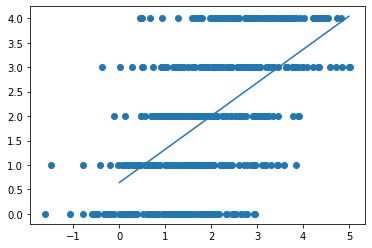

In [12]:
# print(reg_4.coef_, reg_4.intercept_)
# print(reg_5.coef_, reg_5.intercept_)

# fig = plt.figure(figsize = (8, 8))
# ax = plt.axes(projection ="3d")
# ax.scatter3D(mean_rating_per_movie_list, train_set['Rating'], mean_rating_per_user_list, c=train_set['Rating'], s=0.01)
# x = np.linspace(3.0, 4.0, 100)
# y = np.linspace(0.0, 5.0, 10)
# X, Y = np.meshgrid(x, y)
# ax.scatter3D(X, Y, reg_4.coef_[0] * X + reg_4.coef_[1] * Y + reg_4.intercept_, s=0.1)
# ax.scatter3D(X, Y, reg_5.coef_[1] * X + reg_5.coef_[0] * Y + reg_5.intercept_, s=1.0)
# ax.view_init(0, -190)
# plt.show()

# x = np.linspace(0.0, 5.0, 100)
# e = np.random.normal(0, 0.5, 100)
# y = 0.7 * x - 0.3

x = np.array([])
y = np.array([])

for i in np.arange(5):
    x = np.concatenate((x, np.random.normal(1.0 + i * 0.5, 1.0, 100)))
    y = np.concatenate((y, i * np.ones(100)))

lin_reg = LinearRegression(fit_intercept=True).fit(x[..., None], y)

a = lin_reg.coef_[0]
b = lin_reg.intercept_

print(lin_reg.coef_)
print(lin_reg.intercept_)
print(lin_reg.score(x[..., None], y))

plt.plot(np.linspace(0, 5, 100), a * np.linspace(0, 5, 100) + b)
plt.scatter(x, y)
plt.show()